https://langchain-ai.github.io/langgraph/how-tos/react-agent-structured-output/

In [17]:
# !pip install -U langchain
# !pip install -U langchain-openai
# !pip install -U langgraph
# !pip install -U openai

In [1]:
from IPython.display import Image

In [2]:
from pydantic import BaseModel, Field
from typing import  Literal
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

In [3]:
from dotenv import load_dotenv
assert load_dotenv()

In [4]:
Image(url='./react-output.png', width=500)

- 增加一个 respond 节点，做结构化的输出处理；

In [5]:
class WeatherResponse(BaseModel):
    """Respond to the user with this"""
    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(description="The direction of the wind in abbreviated form")
    wind_speed: float = Field(description="The speed of the wind in km/h")

In [6]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages 
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: WeatherResponse

In [7]:
from typing import get_type_hints

In [8]:
get_type_hints(AgentState)

{'messages': list[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage, langchain_core.messages.ai.AIMessageChunk, langchain_core.messages.human.HumanMessageChunk, langchain_core.messages.chat.ChatMessageChunk, langchain_core.messages.system.SystemMessageChunk, langchain_core.messages.function.FunctionMessageChunk, langchain_core.messages.tool.ToolMessageChunk]],
 'final_response': __main__.WeatherResponse}

In [9]:
@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It is cloudy in NYC, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "sf":
        return "It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")

In [10]:
tools = [get_weather]

In [11]:
model = ChatOpenAI(model="gpt-3.5-turbo")

In [12]:
model_w_tools = model.bind_tools(tools)
model_w_output = model.with_structured_output(WeatherResponse)

In [13]:
model_w_output.invoke("what's the weather in SF?")

WeatherResponse(temperature=65.0, wind_directon='NW', wind_speed=10.0)

In [14]:
model_w_tools = model.bind_tools(tools)
# update langchain-openai 等
model_w_output = model.with_structured_output(WeatherResponse, strict=True)

In [15]:
model_w_output.invoke("what's the weather in SF?")

WeatherResponse(temperature=70.0, wind_directon='NW', wind_speed=10.0)

In [21]:
model_w_output.invoke(('Human', "what's the weather in SF?"))

WeatherResponse(temperature=65.0, wind_directon='NW', wind_speed=10.0)

### bind output as tool

In [2]:
Image(url='./imgs/structure_output_option1.png', width=500)

In [3]:
Image(url='./imgs/structure_output_option2.png', width=500)

In [13]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

tools = [get_weather, WeatherResponse]

In [14]:
# Force the model to use tools by passing tool_choice="any"    
model_with_response_tool = model.bind_tools(tools, tool_choice="any")

In [15]:
# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_response_tool.invoke(state['messages'])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [16]:
# Define the function that responds to the user
def respond(state: AgentState):
    # Construct the final answer from the arguments of the last tool call
    response = WeatherResponse(**state['messages'][-1].tool_calls[0]['args'])
    # We return the final answer
    return {"final_response": response}

In [17]:
# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if len(last_message.tool_calls) == 1 and last_message.tool_calls[0]['name'] == "WeatherResponse":
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"

In [18]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

In [19]:
# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

In [20]:
graph.get_graph().edges

[Edge(source='__start__', target='agent', data=None, conditional=False),
 Edge(source='respond', target='__end__', data=None, conditional=False),
 Edge(source='tools', target='agent', data=None, conditional=False),
 Edge(source='agent', target='tools', data='continue', conditional=True),
 Edge(source='agent', target='respond', data=None, conditional=True)]

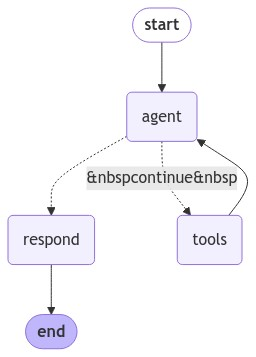

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:
results = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})

In [23]:
results['messages'][-1].tool_calls

[{'name': 'WeatherResponse',
  'args': {'temperature': 75, 'wind_directon': 'SE', 'wind_speed': 3},
  'id': 'call_UYNGeOzmaqiCH9aL5hNpH9t6',
  'type': 'tool_call'}]

In [24]:
results['messages'][0]

HumanMessage(content="what's the weather in SF?", id='9471da80-7e2e-4501-92fd-572d2cd5bd51')

In [25]:
results['messages'][1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7XFIRlmNdITonrRYQaEbTU4A', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 122, 'total_tokens': 134, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-afee47df-ee13-4811-a285-83468f38b2ce-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_7XFIRlmNdITonrRYQaEbTU4A', 'type': 'tool_call'}], usage_metadata={'input_tokens': 122, 'output_tokens': 12, 'total_tokens': 134})

In [26]:
results['messages'][1].additional_kwargs['tool_calls']

[{'id': 'call_7XFIRlmNdITonrRYQaEbTU4A',
  'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'},
  'type': 'function'}]

In [27]:
results['messages'][2]

ToolMessage(content='It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction', name='get_weather', id='c3154fa3-a968-480a-b9e7-ee269def7eb8', tool_call_id='call_7XFIRlmNdITonrRYQaEbTU4A')

In [28]:
results['messages'][3]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UYNGeOzmaqiCH9aL5hNpH9t6', 'function': {'arguments': '{"temperature":75,"wind_directon":"SE","wind_speed":3}', 'name': 'WeatherResponse'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 164, 'total_tokens': 188, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-7897888a-b6a1-4433-afa6-a6ba6ba88344-0', tool_calls=[{'name': 'WeatherResponse', 'args': {'temperature': 75, 'wind_directon': 'SE', 'wind_speed': 3}, 'id': 'call_UYNGeOzmaqiCH9aL5hNpH9t6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 164, 'output_tokens': 24, 'total_tokens': 188})

### `strict=True`

- openai official：https://openai.com/index/introducing-structured-outputs-in-the-api/
    - August 6, 2024
    - gpt-4o-2024-08-06
- langchain 兼容
    - https://api.python.langchain.com/en/latest/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html
    - `llm.bind_tools([GetWeather, GetPopulation], strict = True)`
        -  enforce tool args schema is respected
    -  `llm.with_structured_output`

In [22]:
from enum import Enum
from typing import Union

from pydantic import BaseModel

import openai
from openai import OpenAI

In [24]:
class Table(str, Enum):
    orders = "orders"
    customers = "customers"
    products = "products"

class Column(str, Enum):
    id = "id"
    status = "status"
    expected_delivery_date = "expected_delivery_date"
    delivered_at = "delivered_at"
    shipped_at = "shipped_at"
    ordered_at = "ordered_at"
    canceled_at = "canceled_at"

class Operator(str, Enum):
    eq = "="
    gt = ">"
    lt = "<"
    le = "<="
    ge = ">="
    ne = "!="

class OrderBy(str, Enum):
    asc = "asc"
    desc = "desc"

class DynamicValue(BaseModel):
    column_name: str

class Condition(BaseModel):
    column: str
    operator: Operator
    value: Union[str, int, DynamicValue]

class Query(BaseModel):
    table_name: Table
    columns: list[Column]
    conditions: list[Condition]
    order_by: OrderBy

In [25]:
client = OpenAI()

completion = client.beta.chat.completions.parse(
    model="gpt-4o-2024-08-06",
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant. The current date is August 6, 2024. You help users query for the data they are looking for by calling the query function.",
        },
        {
            "role": "user",
            "content": "look up all my orders in may of last year that were fulfilled but not delivered on time",
        },
    ],
    tools=[
        # model as a tool
        openai.pydantic_function_tool(Query),
    ],
)

In [27]:
from rich.pretty import pprint

In [28]:
pprint(completion)

ParsedChatCompletion[NoneType](
│   id='chatcmpl-ABNQammDTsYCpQb7isHqe9JucjIlW',
│   choices=[
│   │   ParsedChoice[NoneType](
│   │   │   finish_reason='tool_calls',
│   │   │   index=0,
│   │   │   logprobs=None,
│   │   │   message=ParsedChatCompletionMessage[NoneType](
│   │   │   │   content=None,
│   │   │   │   refusal=None,
│   │   │   │   role='assistant',
│   │   │   │   function_call=None,
│   │   │   │   tool_calls=[
│   │   │   │   │   ParsedFunctionToolCall(
│   │   │   │   │   │   id='call_wpjw5jKecUVXyVQbkyTXZSnU',
│   │   │   │   │   │   function=ParsedFunction(
│   │   │   │   │   │   │   arguments='{"table_name":"orders","columns":["id"],"conditions":[{"column":"status","operator":"=","value":"fulfilled"},{"column":"ordered_at","operator":">=","value":"2023-05-01"},{"column":"ordered_at","operator":"<=","value":"2023-05-31"},{"column":"expected_delivery_date","operator":"<","value":{"column_name":"delivered_at"}}],"order_by":"asc"}',
│   │   │   │   │   │   │   name='Query',
│   │   │   │   │   │   │   parsed_arguments=Query(
│   │   │   │   │   │   │   │   table_name=<Table.orders: 'orders'>,
│   │   │   │   │   │   │   │   columns=[<Column.id: 'id'>],
│   │   │   │   │   │   │   │   conditions=[
│   │   │   │   │   │   │   │   │   Condition(column='status', operator=<Operator.eq: '='>, value='fulfilled'),
│   │   │   │   │   │   │   │   │   Condition(
│   │   │   │   │   │   │   │   │   │   column='ordered_at',
│   │   │   │   │   │   │   │   │   │   operator=<Operator.ge: '>='>,
│   │   │   │   │   │   │   │   │   │   value='2023-05-01'
│   │   │   │   │   │   │   │   │   ),
│   │   │   │   │   │   │   │   │   Condition(
│   │   │   │   │   │   │   │   │   │   column='ordered_at',
│   │   │   │   │   │   │   │   │   │   operator=<Operator.le: '<='>,
│   │   │   │   │   │   │   │   │   │   value='2023-05-31'
│   │   │   │   │   │   │   │   │   ),
│   │   │   │   │   │   │   │   │   Condition(
│   │   │   │   │   │   │   │   │   │   column='expected_delivery_date',
│   │   │   │   │   │   │   │   │   │   operator=<Operator.lt: '<'>,
│   │   │   │   │   │   │   │   │   │   value=DynamicValue(column_name='delivered_at')
│   │   │   │   │   │   │   │   │   )
│   │   │   │   │   │   │   │   ],
│   │   │   │   │   │   │   │   order_by=<OrderBy.asc: 'asc'>
│   │   │   │   │   │   │   )
│   │   │   │   │   │   ),
│   │   │   │   │   │   type='function'
│   │   │   │   │   )
│   │   │   │   ],
│   │   │   │   parsed=None
│   │   │   )
│   │   )
│   ],
│   created=1727275028,
│   model='gpt-4o-2024-08-06',
│   object='chat.completion',
│   service_tier=None,
│   system_fingerprint='fp_5050236cbd',
│   usage=CompletionUsage(
│   │   completion_tokens=97,
│   │   prompt_tokens=230,
│   │   total_tokens=327,
│   │   completion_tokens_details={'reasoning_tokens': 0}
│   )
)

In [30]:
completion.choices[0].message.tool_calls[0].function.parsed_arguments

Query(table_name=<Table.orders: 'orders'>, columns=[<Column.id: 'id'>], conditions=[Condition(column='status', operator=<Operator.eq: '='>, value='fulfilled'), Condition(column='ordered_at', operator=<Operator.ge: '>='>, value='2023-05-01'), Condition(column='ordered_at', operator=<Operator.le: '<='>, value='2023-05-31'), Condition(column='expected_delivery_date', operator=<Operator.lt: '<'>, value=DynamicValue(column_name='delivered_at'))], order_by=<OrderBy.asc: 'asc'>)

#### case 2

In [31]:
class Step(BaseModel):
    explanation: str
    output: str

class MathResponse(BaseModel):
    steps: list[Step]
    final_answer: str

In [32]:
client = OpenAI()

completion = client.beta.chat.completions.parse(
    model="gpt-4o-2024-08-06",
    messages=[
        {"role": "system", "content": "You are a helpful math tutor."},
        {"role": "user", "content": "solve 8x + 31 = 2"},
    ],
    response_format=MathResponse,
)

In [33]:
pprint(completion)

ParsedChatCompletion[MathResponse](
│   id='chatcmpl-ABNY4eHyFm5VNB5FgMCaavNalUAuq',
│   choices=[
│   │   ParsedChoice[MathResponse](
│   │   │   finish_reason='stop',
│   │   │   index=0,
│   │   │   logprobs=None,
│   │   │   message=ParsedChatCompletionMessage[MathResponse](
│   │   │   │   content='{"steps":[{"explanation":"Start with the equation 8x + 31 = 2.","output":"8x + 31 = 2"},{"explanation":"Subtract 31 from both sides to isolate the term with x.","output":"8x = 2 - 31"},{"explanation":"Calculate the right side: 2 - 31 equals -29.","output":"8x = -29"},{"explanation":"Divide both sides by 8 to solve for x.","output":"x = \\\\frac{-29}{8}"}],"final_answer":"x = -\\\\frac{29}{8}"}',
│   │   │   │   refusal=None,
│   │   │   │   role='assistant',
│   │   │   │   function_call=None,
│   │   │   │   tool_calls=[],
│   │   │   │   parsed=MathResponse(
│   │   │   │   │   steps=[
│   │   │   │   │   │   Step(explanation='Start with the equation 8x + 31 = 2.', output='8x + 31 = 2'),
│   │   │   │   │   │   Step(
│   │   │   │   │   │   │   explanation='Subtract 31 from both sides to isolate the term with x.',
│   │   │   │   │   │   │   output='8x = 2 - 31'
│   │   │   │   │   │   ),
│   │   │   │   │   │   Step(explanation='Calculate the right side: 2 - 31 equals -29.', output='8x = -29'),
│   │   │   │   │   │   Step(explanation='Divide both sides by 8 to solve for x.', output='x = \\frac{-29}{8}')
│   │   │   │   │   ],
│   │   │   │   │   final_answer='x = -\\frac{29}{8}'
│   │   │   │   )
│   │   │   )
│   │   )
│   ],
│   created=1727275492,
│   model='gpt-4o-2024-08-06',
│   object='chat.completion',
│   service_tier=None,
│   system_fingerprint='fp_b40fb1c6fb',
│   usage=CompletionUsage(
│   │   completion_tokens=125,
│   │   prompt_tokens=127,
│   │   total_tokens=252,
│   │   completion_tokens_details={'reasoning_tokens': 0}
│   )
)

In [34]:
message = completion.choices[0].message
if message.parsed:
    print(message.parsed.steps)
    print(message.parsed.final_answer)
else:
    print(message.refusal)

[Step(explanation='Start with the equation 8x + 31 = 2.', output='8x + 31 = 2'), Step(explanation='Subtract 31 from both sides to isolate the term with x.', output='8x = 2 - 31'), Step(explanation='Calculate the right side: 2 - 31 equals -29.', output='8x = -29'), Step(explanation='Divide both sides by 8 to solve for x.', output='x = \\frac{-29}{8}')]
x = -\frac{29}{8}
